In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.distributed import DistributedSampler
from torch.distributed import init_process_group, destroy_process_group
import torch.multiprocessing as mp
from torchvision.models import resnet50,ResNet50_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch.distributed as dist

class MyDataset(nn.Module):
    def __init__(self,data_dir=r"data/VOCdevkit/VOC2012",image_h=480,image_w=480,is_train=True,trans=None):
        super().__init__()
        self.h,self.w=image_h,image_w
        self.is_train=is_train
        self.images,self.masks=self.read_from_dir(data_dir)
        self.transform=trans
        if self.transform==None:
            if self.is_train:
                self.aug=A.Compose([
                A.Resize(self.h,self.w),
                A.HorizontalFlip(p=0.5),
                A.OneOf([
                A.RandomBrightnessContrast(
                brightness_limit=0.2,contrast_limit=0.2,p=0.5),
                A.Blur()],p=0.5),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]),
                ToTensorV2()
                ])
            else:
                self.aug=A.Compose([
                A.Resize(self.h,self.w),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]),
                ToTensorV2()
                ])
        else:
            self.aug=self.transform
        
    def __getitem__(self,index):
        image=self.images[index]
        mask=self.masks[index]
        image_pil=Image.open(image)
        mask_pil=Image.open(mask)
        image_np=np.array(image_pil)
        mask_np=np.array(mask_pil).astype(np.int64)
        augmented=self.aug(image=image_np,mask=mask_np)
        image=augmented['image']
        mask=augmented['mask']
        mask[mask==255]=-1
        return image,mask
    
    def __len__(self):
        return len(self.images)
        
    def read_from_dir(self,data_dir):
        if self.is_train:
            img_dir=os.path.join(data_dir,"ImageSets","Segmentation","train.txt")
        else:
            img_dir=os.path.join(data_dir,"ImageSets","Segmentation","val.txt")
        file=open(img_dir)
        images=[]
        masks=[]
        for line in file:
            line=line.strip("\n")
            images.append(os.path.join(data_dir,"JPEGImages",line+".jpg"))
            masks.append(os.path.join(data_dir,"SegmentationClass",line+".png"))
        return images,masks

val_ds=DataLoader(MyDataset(is_train=False),batch_size=15,shuffle=False,num_workers=0)
train_ds=DataLoader(MyDataset(is_train=True),batch_size=15,shuffle=False,num_workers=0)

def setup():
    init_process_group("nccl")

class FocalLoss(nn.Module):
    def __init__(self,alpha=0.25,gamma=2,ignore_dix=-1, *args, **kwargs,):
        super().__init__(*args, **kwargs)
        self.alpha=alpha
        self.gamma=gamma
        self.ignore_dix=ignore_dix
    def forward(self,inputs,targets):
        predict=inputs.permute(0,2,3,1).contiguous()
        predict=torch.softmax(predict,dim=-1)
        b,c=predict.size(0),predict.size(3)
        mask=targets!=self.ignore_dix
        predict=predict[mask].view(-1,c)
        targets=targets[mask].view(-1)
        one_hot=torch.eye(c,device=predict.device)
        targets=one_hot[targets].view(-1,c).float()
        FL=((-self.alpha*((1-predict)**self.gamma))*targets*torch.log2(predict+1e-12)).sum(dim=-1)
        return FL.mean()
    
## 定义累加器
class Accumulator():
    def __init__(self,n):
        self.data=[0.0]*n
    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
    def reset(self):
        self.data=[0.0]*len(self.data)
    def __getitem__(self, item):
        return self.data[item]
    
def miou(pred,target,num_classes=21):
    cm=np.zeros((num_classes,num_classes),dtype=np.int64)
    pred=pred.argmax(dim=1)
    y_pred_flat=pred.detach().cpu().numpy().flatten()
    y_true_flat=target.detach().cpu().numpy().flatten()
    for t,p in zip(y_true_flat,y_pred_flat):
        cm[t][p]+=1
    sum_true=np.sum(cm,axis=1)
    sum_pred=np.sum(cm,axis=0)
    tp=np.diag(cm)
    denominator=sum_true+sum_pred-tp
    iou=tp/denominator
    iou[denominator==0]=np.nan
    return np.nanmean(iou)

class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3,stride=1,padding=1):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.conv(x)
    
class PPM(nn.Module):
    def __init__(self,in_channels,bin_sizes=[1,2,3,6]):
        super(PPM,self).__init__()
        out_channels=int(in_channels//len(bin_sizes))
        self.stages=nn.ModuleList()
        for bin_size in bin_sizes:
            self.stages.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin_size),
                ConvBlock(in_channels,out_channels,1,1,0),
            ))
    def forward(self,x):
        _,_,h,w=x.size()
        out=[x]
        for stage in self.stages:
            out.append(F.interpolate(stage(x),size=(h,w),mode='bilinear',align_corners=True))
        output=torch.cat(out,dim=1)
        return output
    
class PSPNet(nn.Module):
    def __init__(self,num_classes=21):
        super(PSPNet,self).__init__()
        self.C=num_classes
        self.backbone=resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.set_dilation(self.backbone)
        self.head=ConvBlock(3,64,kernel_size=3,stride=2,padding=1)
        self.layer1=self.backbone.layer1
        self.layer2=self.backbone.layer2
        self.layer3=self.backbone.layer3
        self.layer4=self.backbone.layer4

        self.ppm=PPM(2048,bin_sizes=[1,2,3,6])

        self.main_conv=nn.Sequential(ConvBlock(4096,512,kernel_size=3,stride=1,padding=1),
                                  ConvBlock(512,256,kernel_size=3,stride=1,padding=1),
                                  ConvBlock(256,self.C,kernel_size=1,stride=1,padding=0))
        self.aux_conv=nn.Sequential(ConvBlock(1024,256,kernel_size=3,stride=1,padding=1),
                          ConvBlock(256,self.C,kernel_size=1,stride=1,padding=0))
    def set_dilation(self,layer,d=2):
        p=d
        s=1
        for n,m in layer.named_modules():
            if n in ["layer3.1.conv2","layer3.2.conv2","layer3.3.conv2","layer3.4.conv2","layer3.5.conv2",
                     "layer.4.0.conv2"]:
                m.dilation=(d,d)
                m.padding=(p,p)
            elif n in ["layer3.0.conv2"]:
                m.stride=(s,s)
            elif n in ["layer3.0.downsample.0"]:
                m.stride=(s,s)
            elif n in ["layer4.1.conv2","layer4.2.conv2"]:
                m.dilation=(2*d,2*d)
                m.padding=(2*p,2*p)
    def forward(self,x):
        _,_,h,w=x.size()
        x=self.head(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x_aux=self.layer3(x)
        x=self.layer4(x_aux)

        x=self.ppm(x)
        x=self.main_conv(x)
        x=F.interpolate(x,size=(h,w),mode='bilinear',align_corners=True)
        aux=self.aux_conv(x_aux)
        aux=F.interpolate(aux,size=(h,w),mode='bilinear',align_corners=True)
        return x,aux

/root/miniconda3/lib/python3.12/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error _ssl.c:983: The handshake operation timed out>
  data = fetch_version_info()


In [2]:
## 定义预测函数
model=PSPNet()
def predict(net,data_iter,num=15,idx=2):
    checkpoint=torch.load("pspnet.pth",weights_only=True)
    load_weights=checkpoint['model_state_dict']
    weights={k[7:] if "module." in k else k :v for k,v in load_weights.items()}
    weights={k : v for k,v in weights.items() if k in net.state_dict().keys()}
    net.load_state_dict(weights)
    iters=iter(data_iter)
    for j in range(idx-1):
        next(iters)
    image,target=next(iters)
    images,targets=[],[]
    net.to(0)
    net.eval()
    with torch.no_grad():
        pred,aux=net(image.to(0))
        iou=miou(pred,target)
        print(iou)
    for i in range(num):
        images.append(image[i].permute(1,2,0).detach().cpu())
        targets.append(target[i].detach().cpu())
    return images,targets,pred

In [3]:
def show(idx=1,is_train=True):
    if is_train:
        origin,targets,preds=predict(model,train_ds,idx=idx)
    else:
        origin,targets,preds=predict(model,val_ds,idx=idx)
    predicted=preds.argmax(1)
    preds=[predicted[i].detach().cpu() for i in range(15)]
    fig,axes=plt.subplots(3,5,figsize=(20,10))
    for i in range(3):
        for j in range(5):
            axes[i,j].imshow(origin[j+i*5])
            axes[i,j].set_xticks(())
            axes[i,j].set_yticks(())
    plt.suptitle('Original Image',fontsize=30)
    fig.tight_layout()
    plt.show()
    fig,axes=plt.subplots(3,5,figsize=(20,10))
    for i in range(3):
        for j in range(5):
            axes[i,j].imshow(targets[j+i*5])
            axes[i,j].set_xticks(())
            axes[i,j].set_yticks(())
    plt.suptitle('Target Image',fontsize=30)
    fig.tight_layout()
    plt.show()
    fig,axes=plt.subplots(3,5,figsize=(20,10))
    for i in range(3):
        for j in range(5):
            axes[i,j].imshow(preds[j+i*5])
            axes[i,j].set_xticks(())
            axes[i,j].set_yticks(())
    plt.suptitle('Predicted Image',fontsize=30)
    fig.tight_layout()
    plt.show()

/tmp/ipykernel_1342/934222388.py:123: RuntimeWarning: invalid value encountered in divide
  iou=tp/denominator
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to

0.621762041746799


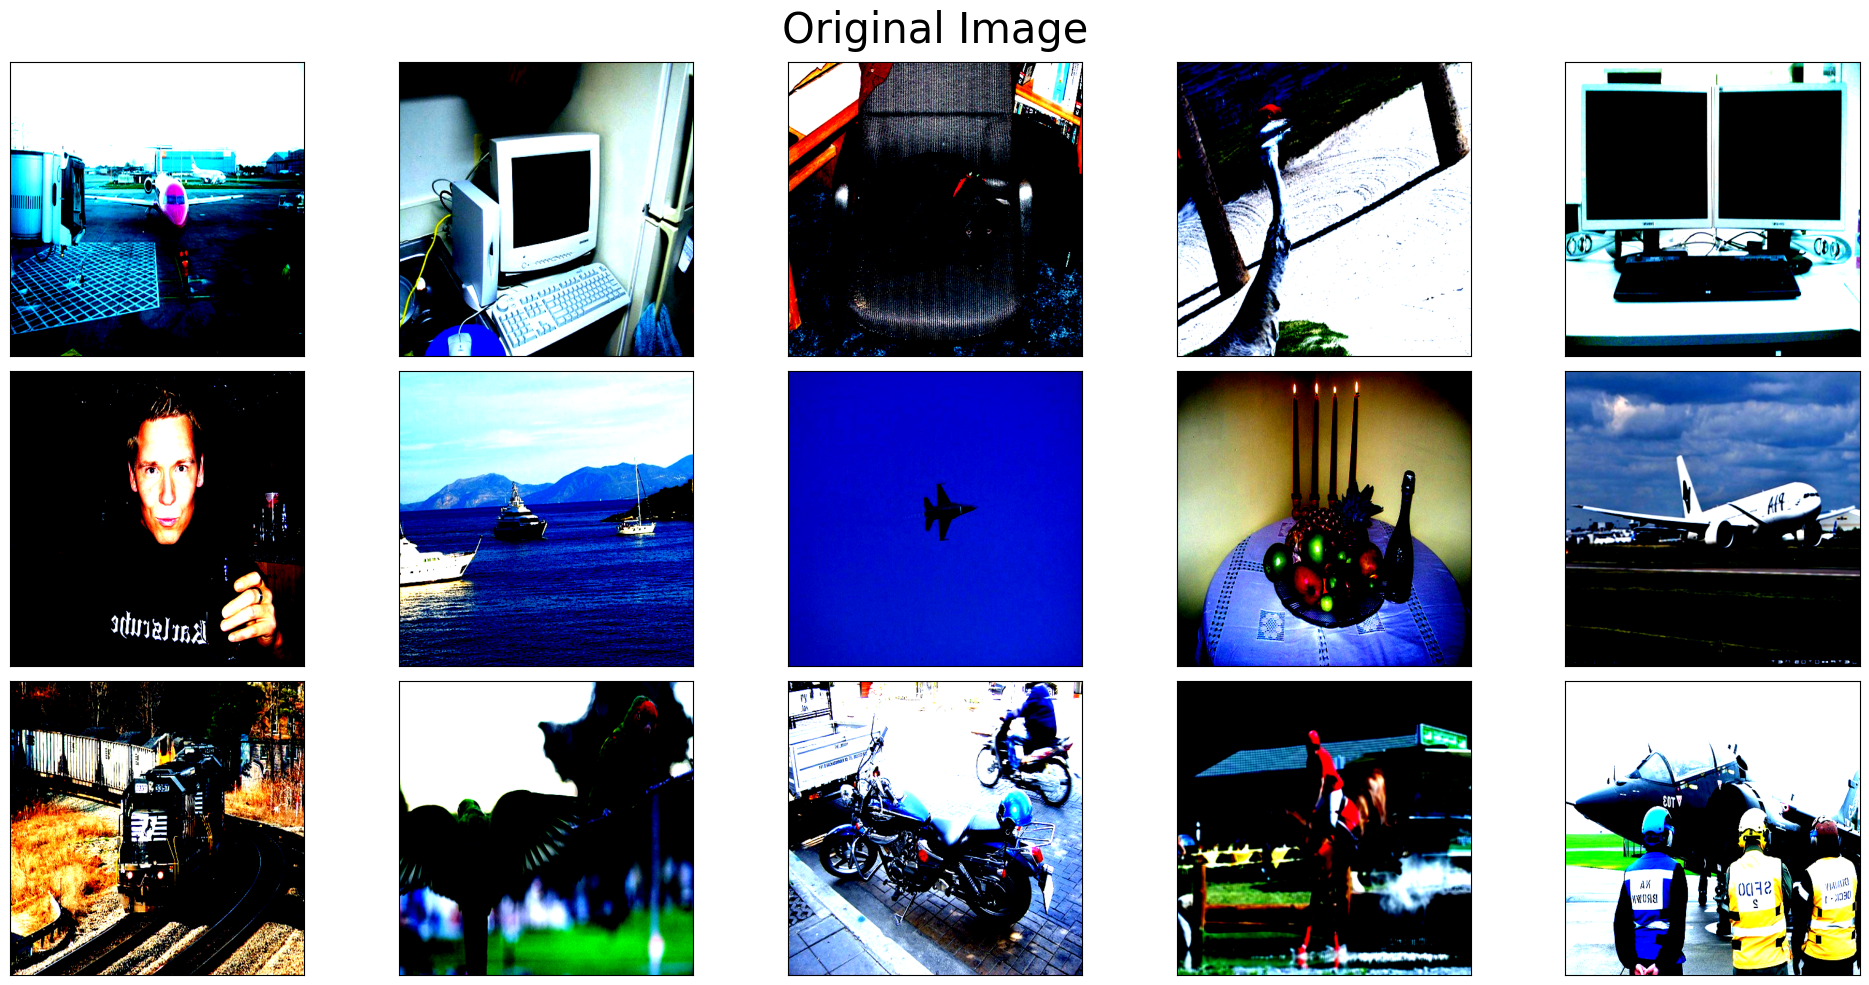

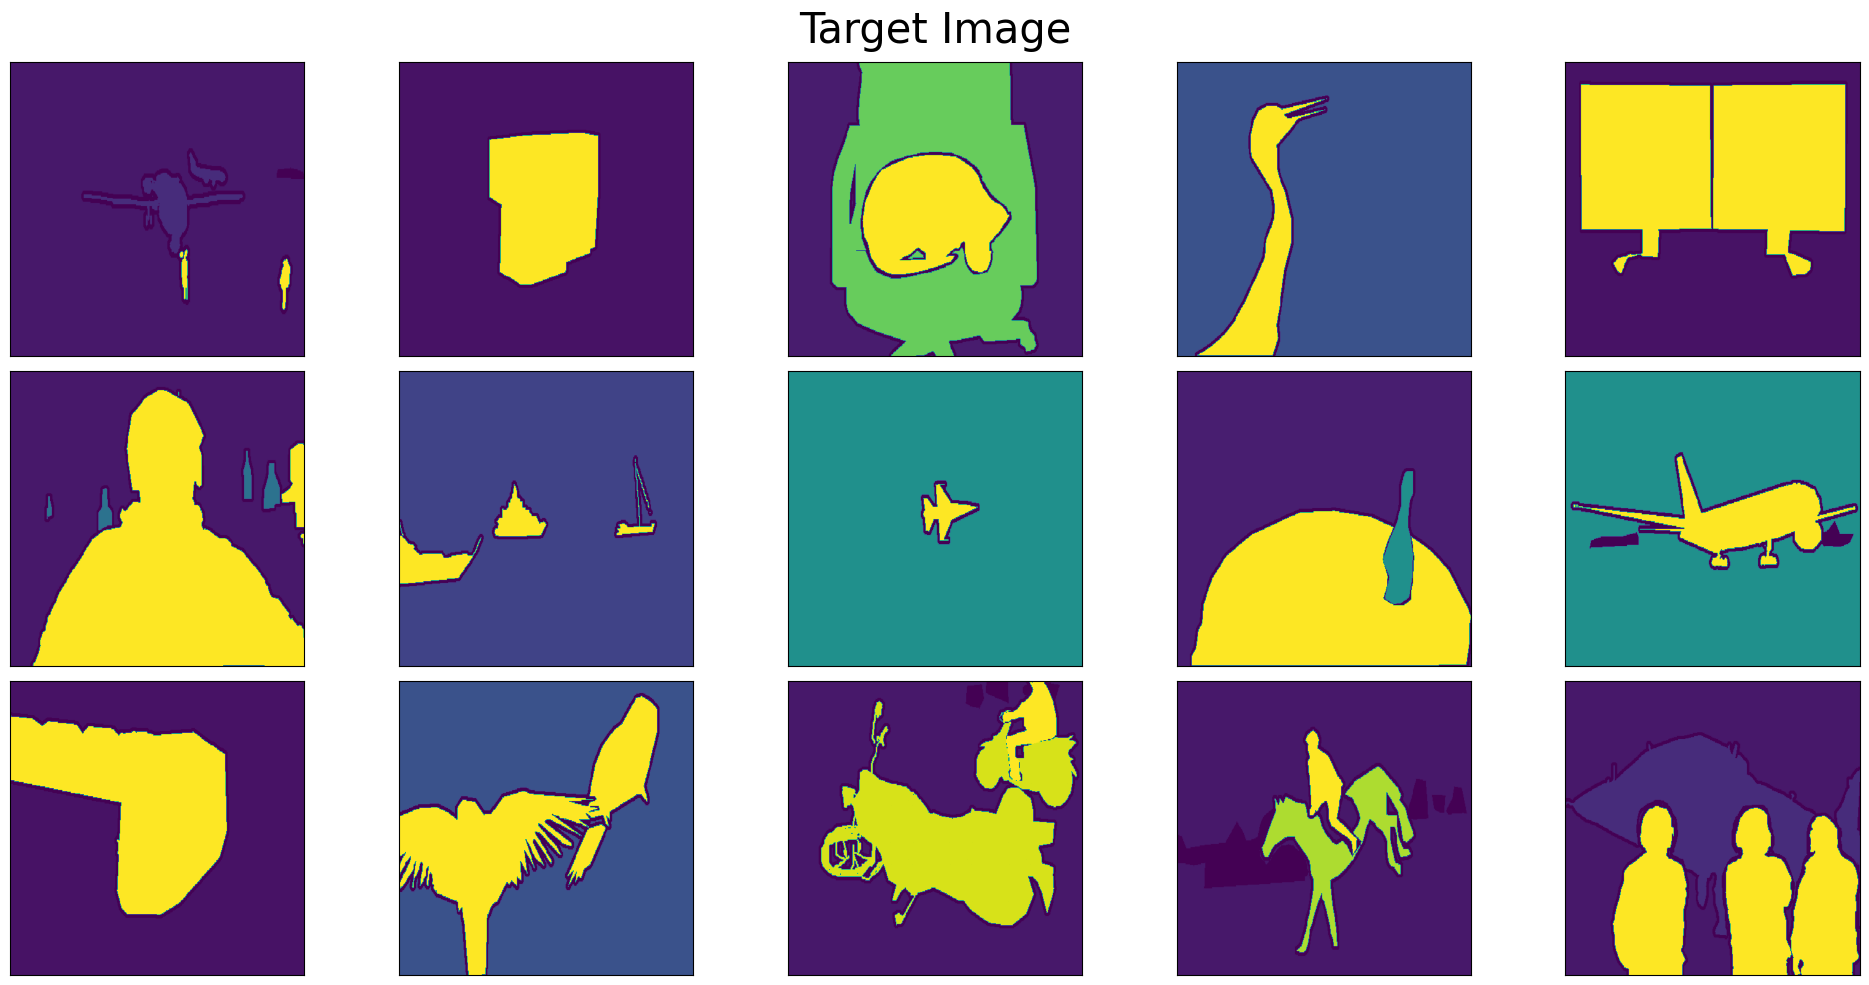

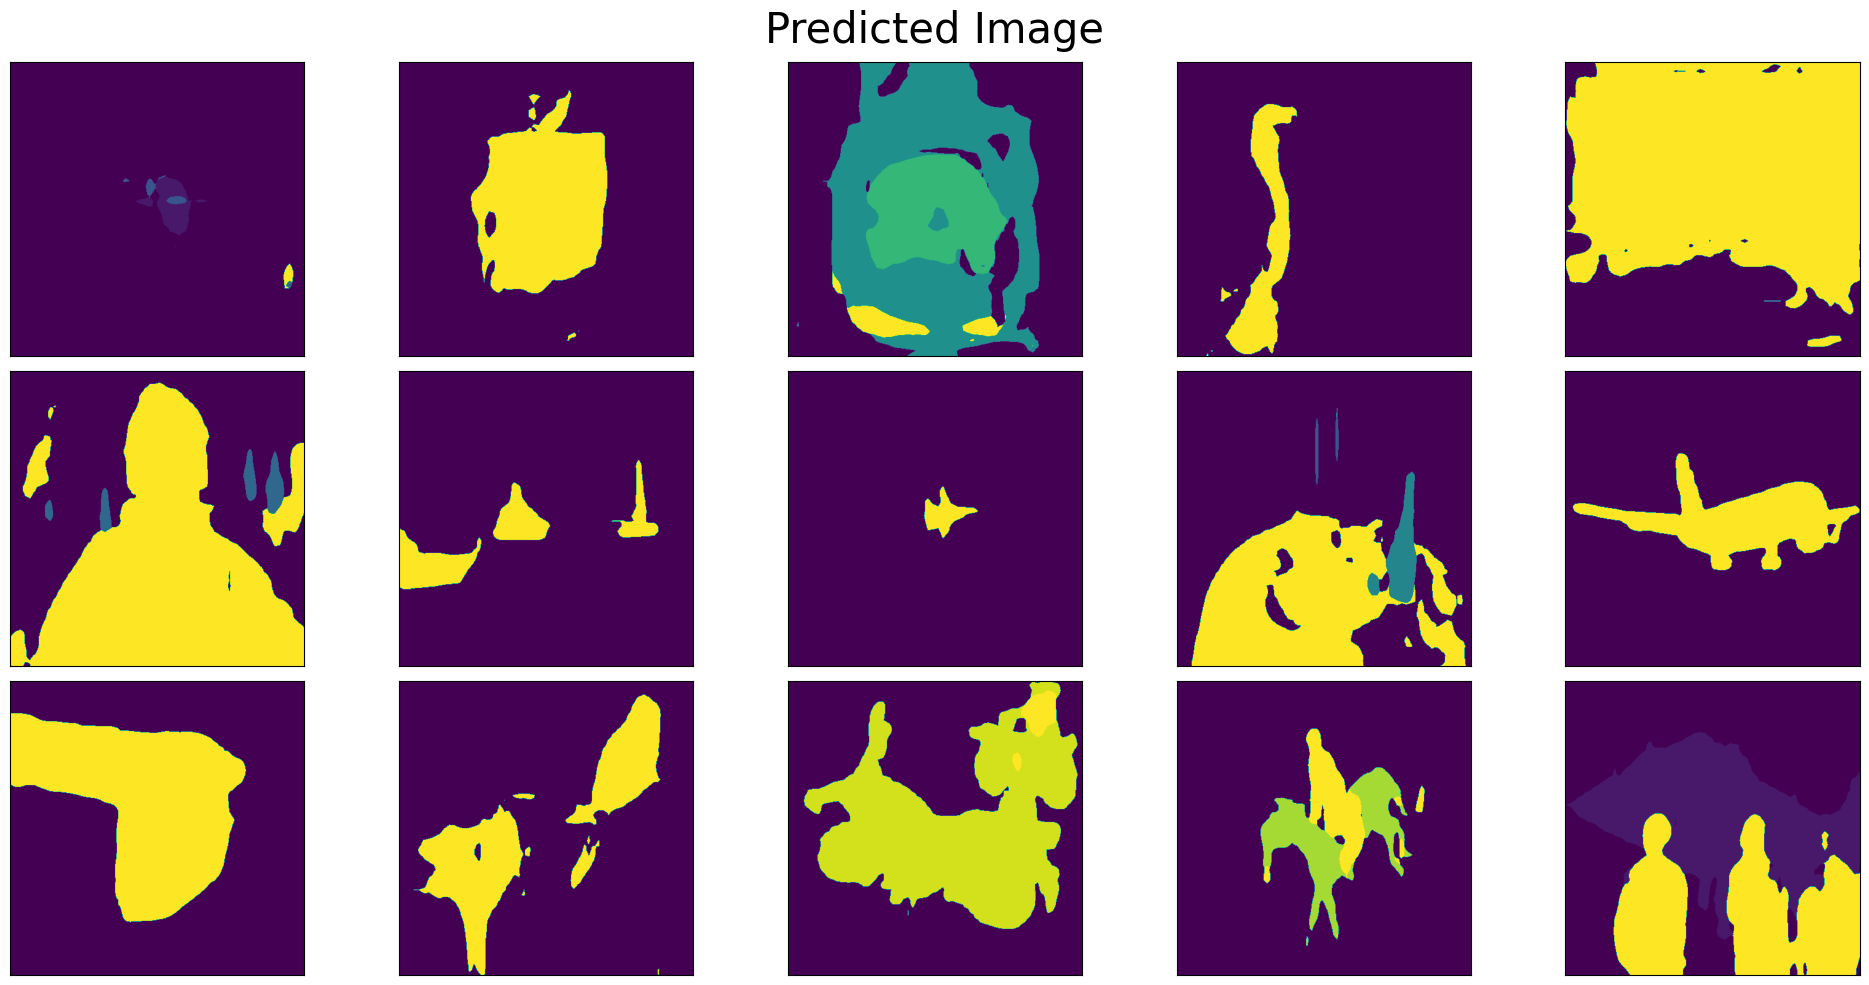

In [9]:
show(idx=1,is_train=True)

/tmp/ipykernel_1342/934222388.py:123: RuntimeWarning: invalid value encountered in divide
  iou=tp/denominator
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2146587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6399999].
Clipping input data t

0.2971948623929558


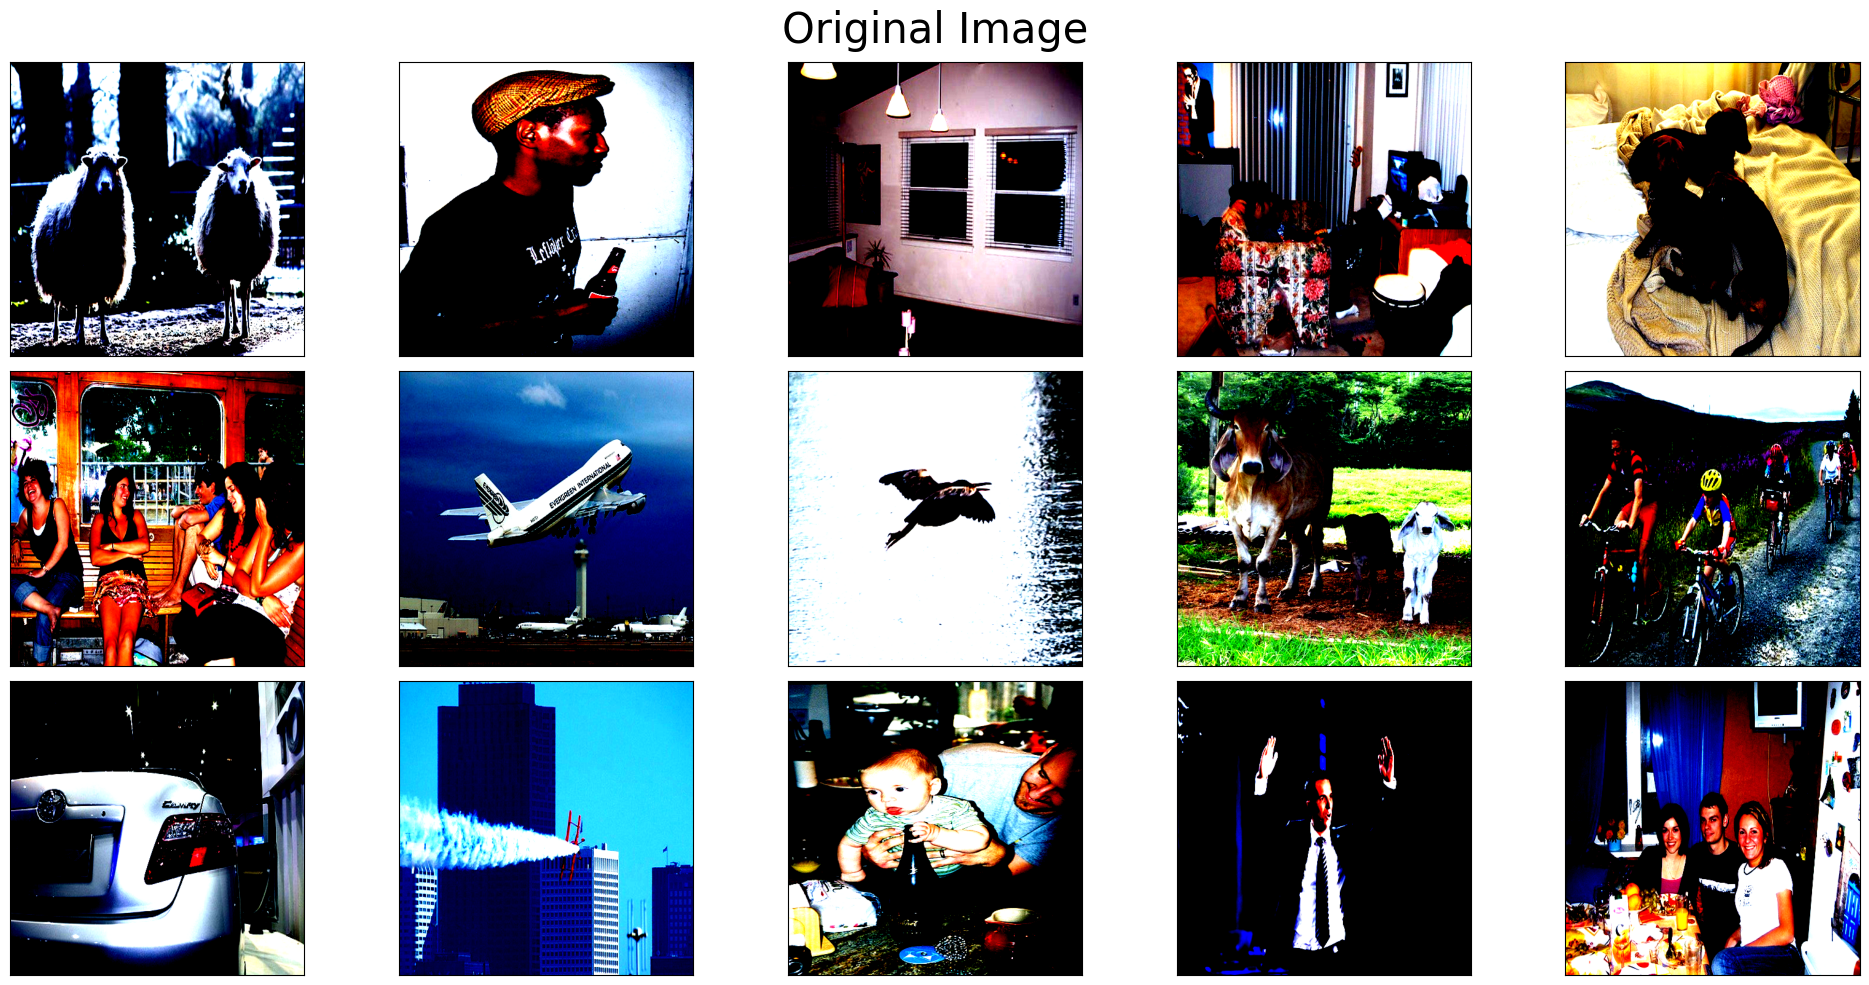

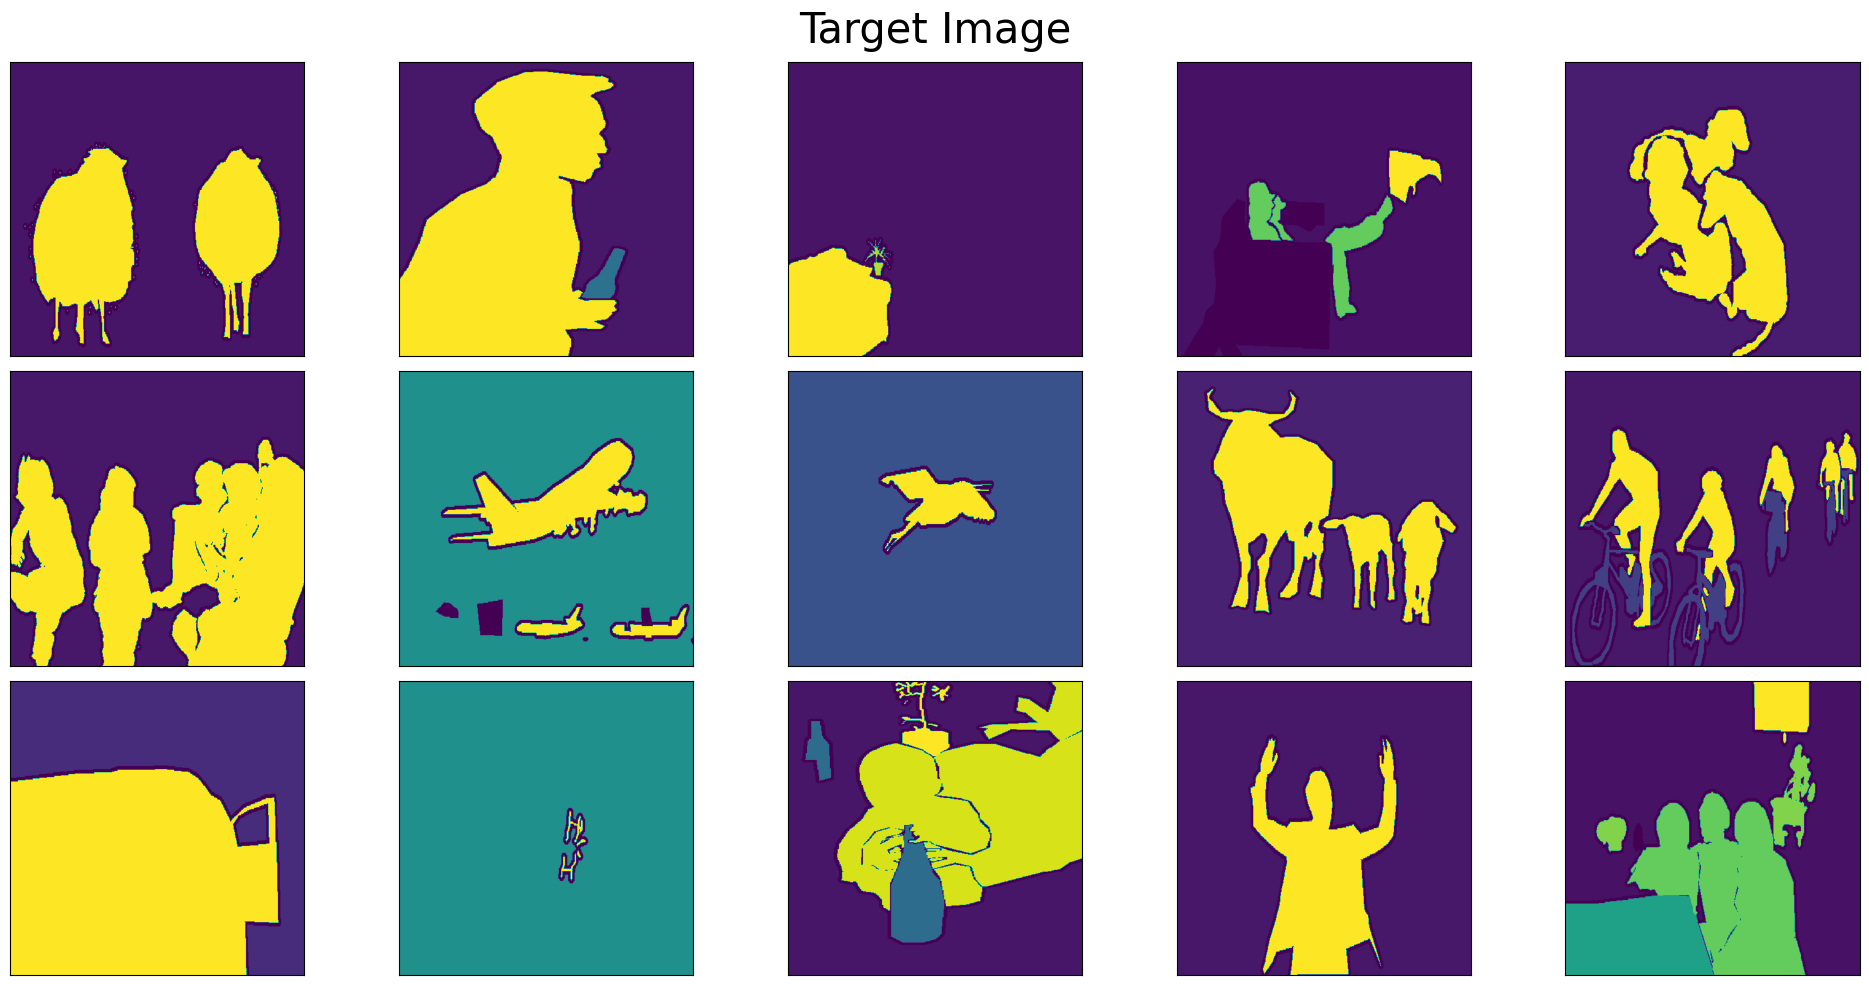

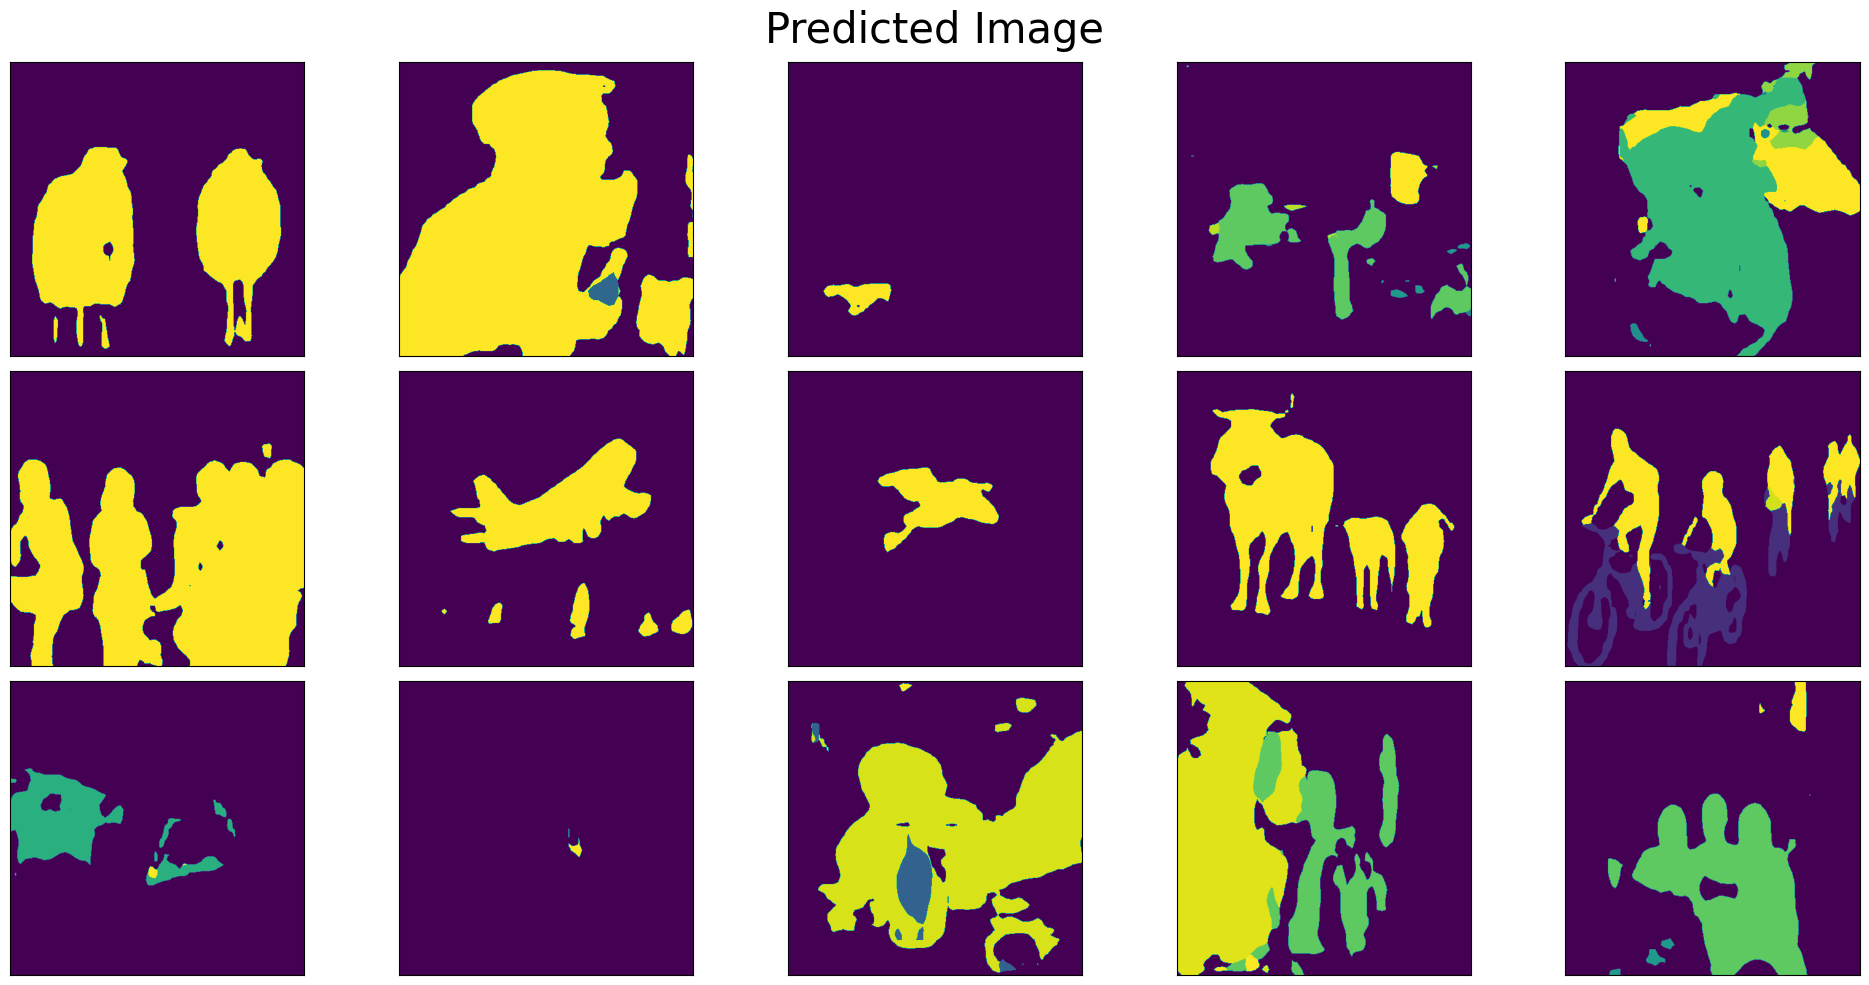

In [6]:
show(idx=3,is_train=False)

## 恭喜你完成了一个PSPNet！
### 由于计算资源限制，以及我采用的神经骨干网络和图片分辨率的缘故，模型效果并未发挥到极致
### 读者可以使用轻量化网络结构MobileNet作为骨干网络，也可以将分辨率大小调节至473~730左右并采用混合精度训练以提高训练精度